In [1]:

from pathlib import Path

# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "TORCH_SEED"  :     17,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0, 0.2], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},
    "MIN_SEQ_LENGTH":   60, # minimum sequence length in seconds

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", 
                         "bs_brk_cval", "elcomp_pwrcons_cval","epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 
                         'brktempra_cval', 'selgr_rq_pt', 'emot_pwr_cval', 'hv_batavcelltemp_cval_bms1', 'txoiltemp_cval_tcm', 'actualspeed_pti1',
                         'actualtorque_pti1', 'maxtracpwrpct_cval', 'actdrvtrnpwrprc_cval', 'brc_stat_brc1', 'hv_ptc_cabin1_pwr_cval'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      400,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.5,
    "SEQ_LENGTH":       60,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       100,
    "BATCH_SIZE":       32,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    3e-3,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)",      
                            # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                            # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                            # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-7)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", #['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']


    # METRICS: ---------------------------------------------------------------------

    # SAVE & LOAD: -----------------------------------------------------------------

}

for key in CONFIG: globals()[key] = CONFIG[key]
print(f"ROOT: {ROOT}")

ROOT: /home/sieglew/MA-eR-PINN


In [2]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
global ROOT, DATA_PATH
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.TripDataset import *
from src.utils.train_model import *

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32); torch.manual_seed(TORCH_SEED);

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from pytorch_forecasting.metrics import MASE
#from darts import TimeSeries
#from darts.models import ExponentialSmoothing

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode


In [3]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")

------------------------------------------------------------
Torch version:  2.4.1+cu121
Using: -->  CUDA:0


In [4]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files[:MAX_FILES]
print(f"{'-'*60}\nTotal Files:\t{len(files)}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 44

# FILTER INPUT FILES --------------------------------------------------------
# generate lengths of all files by reading metadata or using presaved lengths
try:
    presaved_lengths = pd.read_pickle(Path(ROOT, 'data', 'df_files_lengths.pickle'))
    presaved_lengths = presaved_lengths.set_index('FileName').to_dict()['Length']
    trip_lengths = [presaved_lengths[file.name] for file in files]
except:
    print(f"{'-'*60}\nObtaining sequence lengths... (may take up to 5 minutes)")
    trip_lengths = [pq.read_metadata(file).num_rows for file in files]

# discard all items shorter than min_seq_length
min_seq_length = MIN_SEQ_LENGTH
filtered_files = []
filtered_lengths = []
for file, length in zip(files, trip_lengths):
    if length > min_seq_length: 
        filtered_files.append(file)
        filtered_lengths.append(length)

# replace lists with only filtered items
files = filtered_files
trip_lengths = filtered_lengths
print(f"Filtered Files:\t{len(files)}\n{'-'*60}")


------------------------------------------------------------
Input Data:	/home/sieglew/MA-Data/TripSequences/trips_processed_final
Store model in:	/home/sieglew/MA-eR-PINN/src/models/pth
------------------------------------------------------------
Total Files:	18629
Filtered Files:	18629
------------------------------------------------------------


In [5]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
"hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "hirestotalvehdist_cval_icuc"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

# FEATURE SELECTION  --------------------------------------
# ---------------------------------------------------------
target_column = TARGETS
input_columns = FEATURES
#input_columns = list(set(all_signals) - set(columns_to_drop) - set(target_column)) # include target to generate one DF

In [6]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])

# DATA SET SPLITTING -----------------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

/home/sieglew/.local/lib/python3.11/site-packages/torch/utils/data/dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [7]:
def get_data(subset, columns):
    all_data = []
    for n, f in enumerate(subset):
        print(n)
        df = pd.read_parquet(f,columns = columns, engine='pyarrow')
        all_data.append(df[columns].values)

    all_data = np.concatenate(all_data, axis=0)

    # Convert to DataFrame
    all_data_df = pd.DataFrame(all_data, columns=columns)
    return all_data_df

X_train = get_data(train_subset, input_columns)
#X_train.to_parquet(Path(pth_folder, "X_train_xgboost.parquet"), engine='pyarrow', compression='snappy')

y_train = get_data(train_subset, target_column)
#y_train.to_parquet(Path(pth_folder, "y_train_xgboost.parquet"), engine='pyarrow', compression='snappy')

X_test = get_data(test_subset, input_columns)
#X_test.to_parquet(Path(pth_folder, "X_test_xgboost.parquet"), engine='pyarrow', compression='snappy')

y_test = get_data(test_subset, target_column)
#y_test.to_parquet(Path(pth_folder, "y_test_xgboost.parquet"), engine='pyarrow', compression='snappy')

print(f"All data saved.")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
#X_train = pd.read_parquet(Path(DATA_PATH, "X_train_xgboost.parquet"), engine='pyarrow')
#y_train = pd.read_parquet(Path(DATA_PATH, "y_train_xgboost.parquet"), engine='pyarrow')
#X_test = pd.read_parquet(Path(DATA_PATH, "X_test_xgboost.parquet"), engine='pyarrow')
#y_test = pd.read_parquet(Path(DATA_PATH, "y_test_xgboost.parquet"), engine='pyarrow')


In [9]:
# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,            # default: 6, increase for more complex models
    'learning_rate': 0.2,       # default: 0.3, decrease for more stable training
    'subsample': 0.8,           # default: 1, reduce to prevent overfitting
    'colsample_bytree': 0.8,    # default: 1, reduce to prevent overfitting
    'n_estimators': 1000,       # increase for better performance, but with longer training time
    'tree_method': 'hist',      # 'gpu_hist' for GPU, 'hist' for CPU, 'approx' for faster training
    'device': 'cuda'            # 'cpu' or 'cuda' for specific hardware
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], verbose_eval=True)

# OR
#xgb_model = XGBRegressor(**params)
#xgb_model.fit(X_train, y_train)



/home/sieglew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:27:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-rmse:19.72637
[1]	test-rmse:18.59598
[2]	test-rmse:17.67532
[3]	test-rmse:16.96526
[4]	test-rmse:16.44724
[5]	test-rmse:16.08641
[6]	test-rmse:15.81484
[7]	test-rmse:15.49611
[8]	test-rmse:15.30490
[9]	test-rmse:15.18571
[10]	test-rmse:15.04062
[11]	test-rmse:14.95522
[12]	test-rmse:14.84476
[13]	test-rmse:14.72876
[14]	test-rmse:14.63052
[15]	test-rmse:14.56838
[16]	test-rmse:14.49741
[17]	test-rmse:14.43988
[18]	test-rmse:14.40771
[19]	test-rmse:14.37903
[20]	test-rmse:14.34641
[21]	test-rmse:14.31559
[22]	test-rmse:14.26765
[23]	test-rmse:14.21706
[24]	test-rmse:14.12221
[25]	test-rmse:14.05737
[26]	test-rmse:13.95435
[27]	test-rmse:13.93212
[28]	test-rmse:13.91665
[29]	test-rmse:13.90255
[30]	test-rmse:13.81136
[31]	test-rmse:13.78503
[32]	test-rmse:13.67225
[33]	test-rmse:13.65289
[34]	test-rmse:13.59730
[35]	test-rmse:13.58960
[36]	test-rmse:13.58365
[37]	test-rmse:13.56951
[38]	test-rmse:13.55239
[39]	test-rmse:13.53719
[40]	test-rmse:13.50582
[41]	test-rmse:13.42317
[4

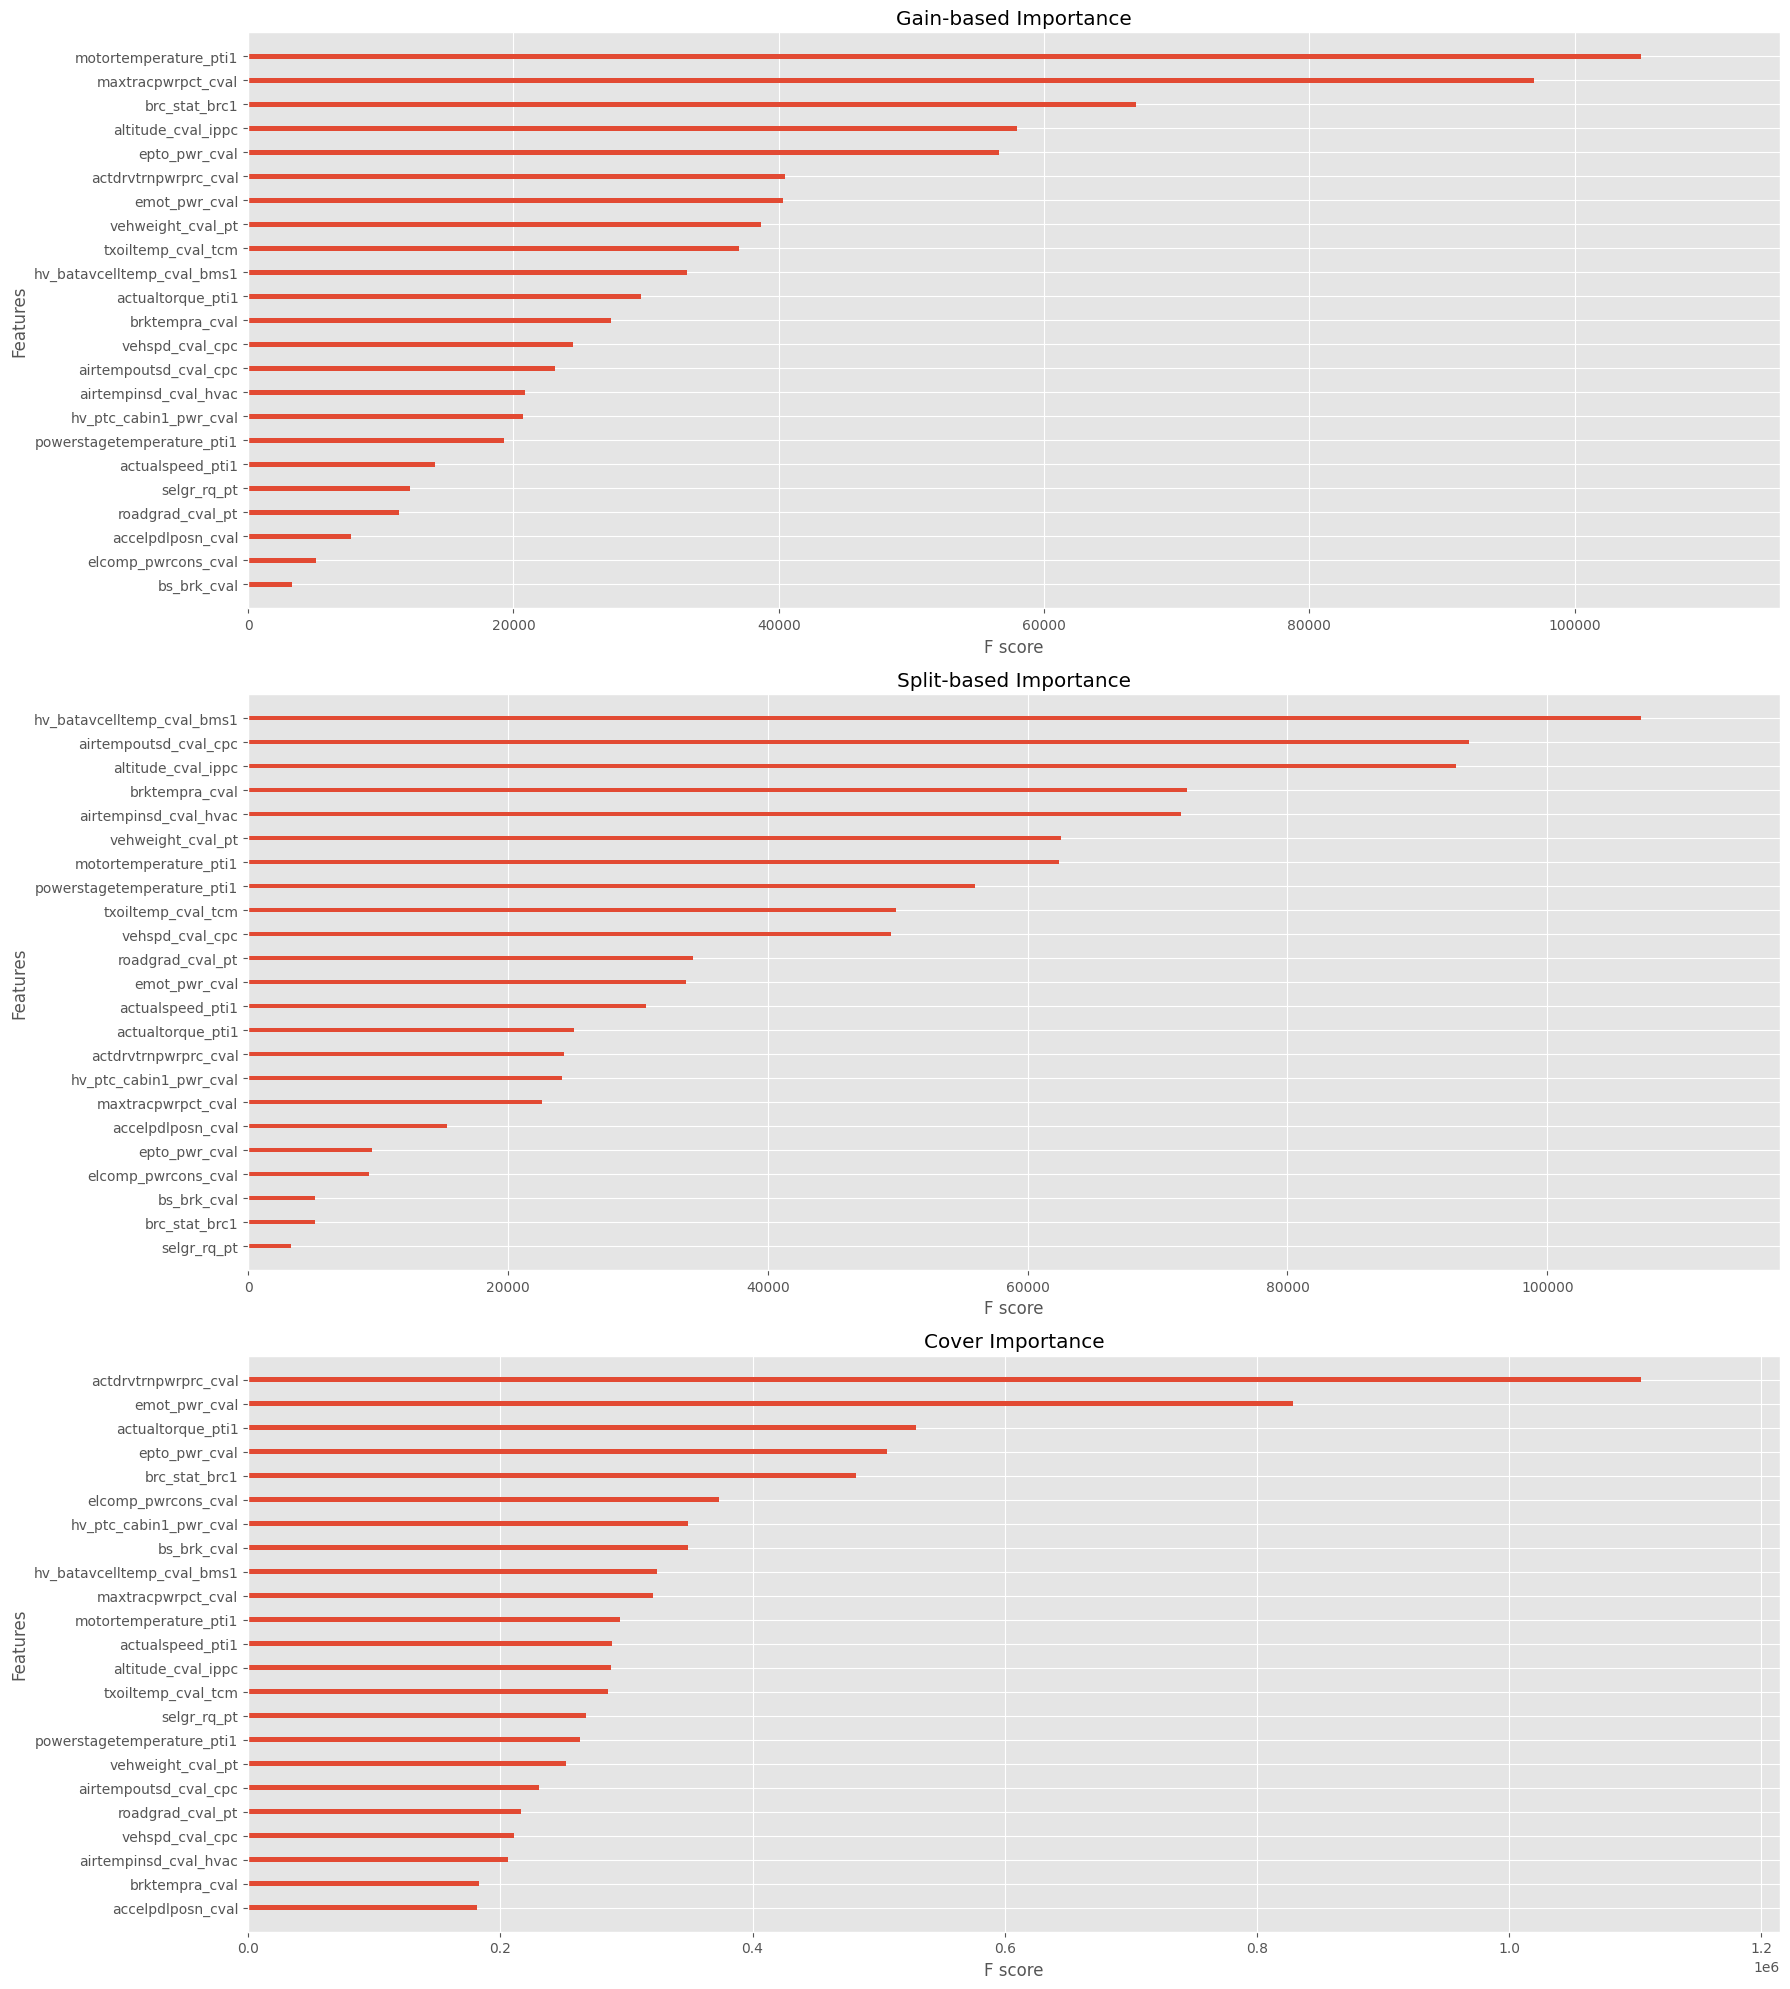

In [11]:
'''XGBoost offers three main types of feature importance scores:

    Gain-based Importance: This score measures the average gain of splits that use a particular feature. The gain represents the improvement in 
                            accuracy brought by a feature to the branches it is on. Features with higher gain are considered more important. 
                            Gain-based importance is useful for assessing a feature’s general utility, especially in tree-based models. However, 
                            it can be biased towards high-cardinality features.
    Split-based Importance: Also known as “weight” or “frequency” importance, this score counts the number of times a feature is used to split 
                            the data across all trees in the model. Features used more frequently are deemed more important. Split-based importance 
                            is simple and intuitive, making it useful for quick, initial feature filtering or when interpretability is crucial. However, 
                            it doesn’t account for a feature’s actual impact on predictions.
    Cover-based Importance: This score measures the average coverage of splits that use the feature. Coverage represents the number of samples affected 
                            by the split.
'''

# Calculate and plot different feature importance scores
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 20))

xgb.plot_importance(xgb_model, ax=ax1, importance_type='gain', title='Gain-based Importance', show_values=False)
xgb.plot_importance(xgb_model, ax=ax2, importance_type='weight', title='Split-based Importance', show_values=False)
xgb.plot_importance(xgb_model, ax=ax3, importance_type='cover', title='Cover Importance', show_values=False)

plt.tight_layout()
plt.show()

In [12]:
# ---------------------------------------------------
# Make predictions
y_pred = xgb_model.predict(dtest)
#y_pred = xgb_model.predict(X_test)


# --------------------------------------------------
# Evaluate the metrics
y_pred = y_pred.flatten()
y_test = y_test.values.flatten()
residuals = y_test - y_pred
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred)}")
print(f"R-squared: {r2_score(y_test, y_pred)}")
print(f"Standard Deviation of Residuals: {np.std(residuals)}")

Mean Absolute Error: 8.6745212809862
Mean Squared Error: 138.65199307504645
Root Mean Squared Error: 11.77505809221536
R-squared: 0.6983039925372163
Standard Deviation of Residuals: 11.774855763923268
